# **Imports**

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset**

## Transform

In [3]:
transform_train = T.Compose([T.ToTensor(),
                             T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                         std=(0.2023, 0.1994, 0.2010))])

transform_test = T.Compose([T.ToTensor(),
                            T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                        std=(0.2023, 0.1994, 0.2010))])

## CIFAR Dataset

In [4]:
train_set = CIFAR10(root='/content/drive/MyDrive/colab_projects/Convolutional Neural Networks', train=True,
                    download=True,
                    transform=transform_train)

test_set = CIFAR10(root='/content/drive/MyDrive/colab_projects/Convolutional Neural Networks', train=False,
                   download=True,
                   transform=transform_test)

100%|██████████| 170498071/170498071 [00:02<00:00, 75628087.40it/s]


Extracting /content/drive/MyDrive/colab_projects/Convolutional Neural Networks/cifar-10-python.tar.gz to /content/drive/MyDrive/colab_projects/Convolutional Neural Networks
Files already downloaded and verified


## Dataloader

In [5]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [6]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([9, 9, 5, 4, 5, 1, 9, 9, 4, 2, 0, 8, 0, 4, 9, 1, 4, 8, 4, 4, 8, 9, 7, 3,
        3, 5, 3, 4, 4, 6, 2, 0, 6, 9, 6, 8, 0, 9, 4, 4, 4, 6, 9, 4, 3, 7, 0, 0,
        2, 2, 4, 5, 4, 0, 7, 5, 7, 2, 1, 1, 1, 4, 9, 8])


## Visualize

In [7]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

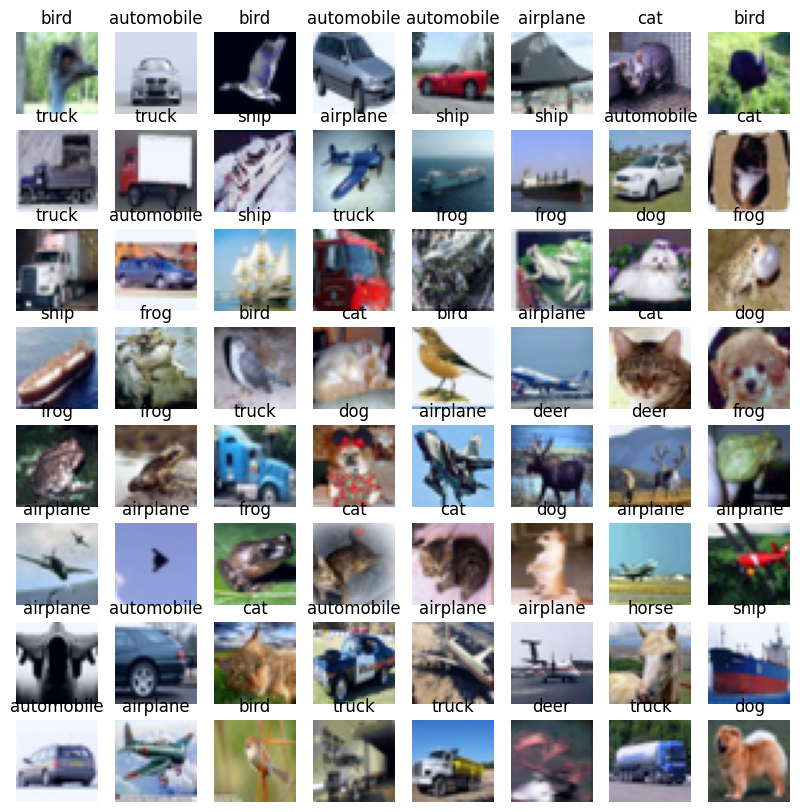

In [8]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model**

In [9]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [10]:
def CNN():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          conv3x3_bn_af(64, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          conv3x3_bn_af(128, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          conv3x3_bn_af(256, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          conv3x3_bn_af(512, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

# **Device**

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

# **Loss & Optimizer**

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Utils**

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions**

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=10).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [15]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=10).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Setting Hyperparameters**

In [16]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.4139, grad_fn=<NllLossBackward0>)


In [17]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [18]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 50/50 [00:34<00:00,  1.43batch/s, accuracy=99.9, loss=0.0866]


In [19]:
model = CNN().to(device)
lr = 0.05
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [20]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [22]:
num_epochs = 5

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [25:52<00:00,  1.98s/batch, accuracy=60.9, loss=1.08]


Valid: Loss = 1.466, Acc = 0.5337



Epoch 1: 100%|██████████| 782/782 [25:08<00:00,  1.93s/batch, accuracy=76.9, loss=0.655]


Valid: Loss = 1.111, Acc = 0.6399



Epoch 2: 100%|██████████| 782/782 [25:35<00:00,  1.96s/batch, accuracy=82.8, loss=0.496]


Valid: Loss = 0.9411, Acc = 0.6999



Epoch 3: 100%|██████████| 782/782 [26:31<00:00,  2.03s/batch, accuracy=86.6, loss=0.384]


Valid: Loss = 0.71, Acc = 0.7661



Epoch 4: 100%|██████████| 782/782 [26:35<00:00,  2.04s/batch, accuracy=89.9, loss=0.292]


Valid: Loss = 0.6959, Acc = 0.7803



# **Plot**

# **Plot**

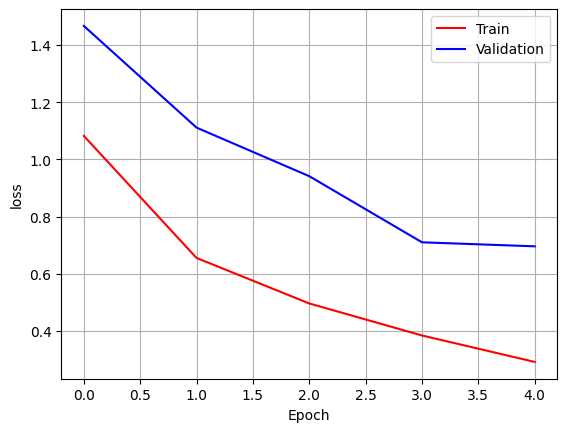

In [23]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

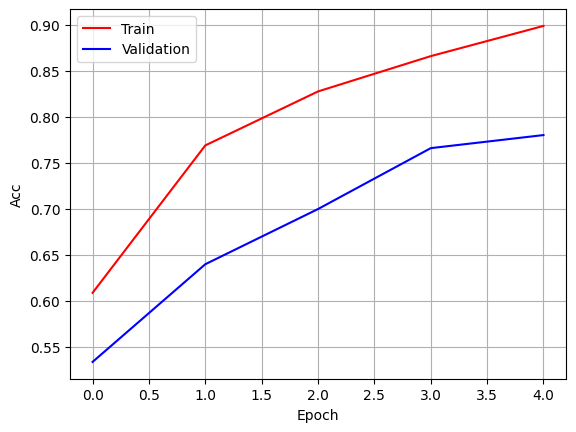

In [24]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()